In [1]:
import numpy as np
from image_alignment import ImageAligner
from datalib import *
from skimage import io
import os
from scipy.ndimage import gaussian_filter
import pandas

wavelength_to_index = lambda x, wavelengths: np.argmin( np.abs( wavelengths - x ) )

In [2]:
%load_ext autoreload

In [3]:
%autoreload 1
%autoreload 2

# 1. Load the two modalities

## 1.1 ICP-MS

In [4]:
main_dir = r"E:/Data/Data_LIBS/Data_Brno/"
sample_dir = r"P36 - Epithelioid angiosarcoma//"
dir_ICP = main_dir + sample_dir + r"LA-ICP-MS//P36B//Export//"

def read_metadata(file1):
    df = pandas.read_csv(file1,encoding = "ISO-8859-1",header=None)
    map_dims = [float(df[1][0].split('x')[0]),float(df[1][0].split('x')[1])]
    spot_dims = [float(df[1][1].split('x')[0]),float(df[1][1].split('x')[1])]
    return map_dims, spot_dims

def read_icp(folder, name='Total'):
    file1 = [folder+'//'+f for f in os.listdir(folder) if f.endswith('csv') and 'metadata' in f]
    print(file1)
    map_dims, spot_dims = read_metadata(file1[0])
    files = [folder+'//'+f for f in os.listdir(folder) if f.endswith('csv') and name in f]
    df = pandas.read_csv(files[0],encoding = "ISO-8859-1",header=None)
    df = df.fillna(0)
    data = df.to_numpy()
    data-=data.min()+1
    return map_dims, spot_dims, data

names_ICP = ['Mg','Cu','Fe']
_, _, data = read_icp(dir_ICP,name=names_ICP[0])
modality1 = abs(data)**(0.3)

['E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma//LA-ICP-MS//P36B//Export////P36 metadata.csv']


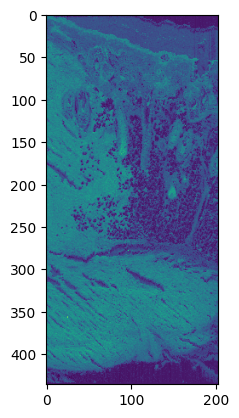

In [5]:
plt.figure()
plt.imshow(modality1)

## 1.2 Optical

In [6]:
main_dir = r"E:/Data/Data_LIBS/Data_Brno/"
sample_dir = r"P36 - Epithelioid angiosarcoma//"
dir_image = main_dir + sample_dir + r"Histology//"

def read_image(folder, index = 0):
    files = [folder + '//' + f for f in os.listdir(folder) if f.endswith('jpg')]
    return io.imread(files[index])

sample_image = read_image(dir_image)

In [7]:
modality2 = sample_image[:, 285:1420, 0]

# 2. Align

In [16]:
# Downsample and Apply Gaussian Filter to reduce noise
%matplotlib widget
step_mod1 = 2
mod1 = gaussian_filter(modality1[::step_mod1, ::step_mod1], sigma = 0.5).T[::-1, ::]
mod1 = np.array(mod1)

step_mod2 = 4
mod2 = gaussian_filter(modality2[::step_mod2, ::step_mod2], sigma  = 0.5)

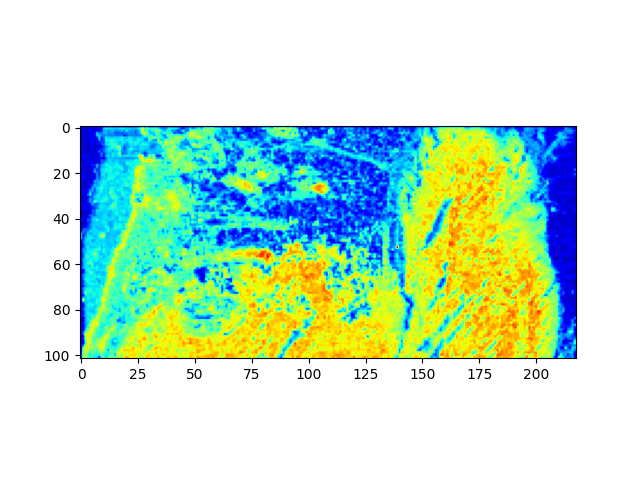

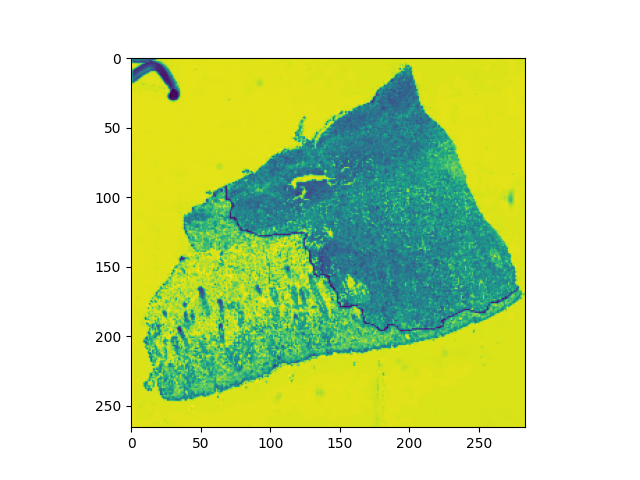

In [17]:
plt.figure()
plt.imshow(mod1, cmap = 'jet')

plt.figure()
plt.imshow(mod2)

## 2.1 Manual Alingment

In [18]:
aligner = ImageAligner(mod1, mod2, device = 'cpu')

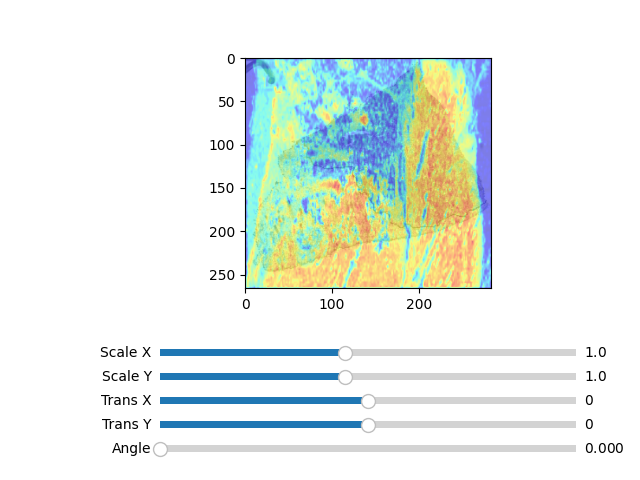

Initial alignment parameters: {'scale_x': 1.0, 'scale_y': 1.0, 'translate': [0.0, 0.0], 'rot_angle': 0.0}


In [19]:
%matplotlib widget
initial_params = aligner.manual_align()

## 2.2 Automatic Fine Tuning

In [88]:
optimizer_params = {
    'optim': 'SGD',
    'lr': 1e-3, # 1e-3 a 1e-4
    'momentum': 0.8, # 0.8 a 0.9
    'num_iters': 500,
}

transform_params = {
    's_tol': 0.1,
    't_tol': 0.1,
    'a_tol': 0.1,
    'edge_align': False # Amostras com pouca estrutura
}

In [89]:
final_params = aligner.auto_align(optimizer_params, transform_params)
print("Final alignment parameters:", final_params)

Final alignment parameters: {'rot_angle': 4.217573642730713, 'translate': [-0.11748137325048447, 0.0691518560051918], 'scale_x': 0.5929079055786133, 'scale_y': 0.25469544529914856}


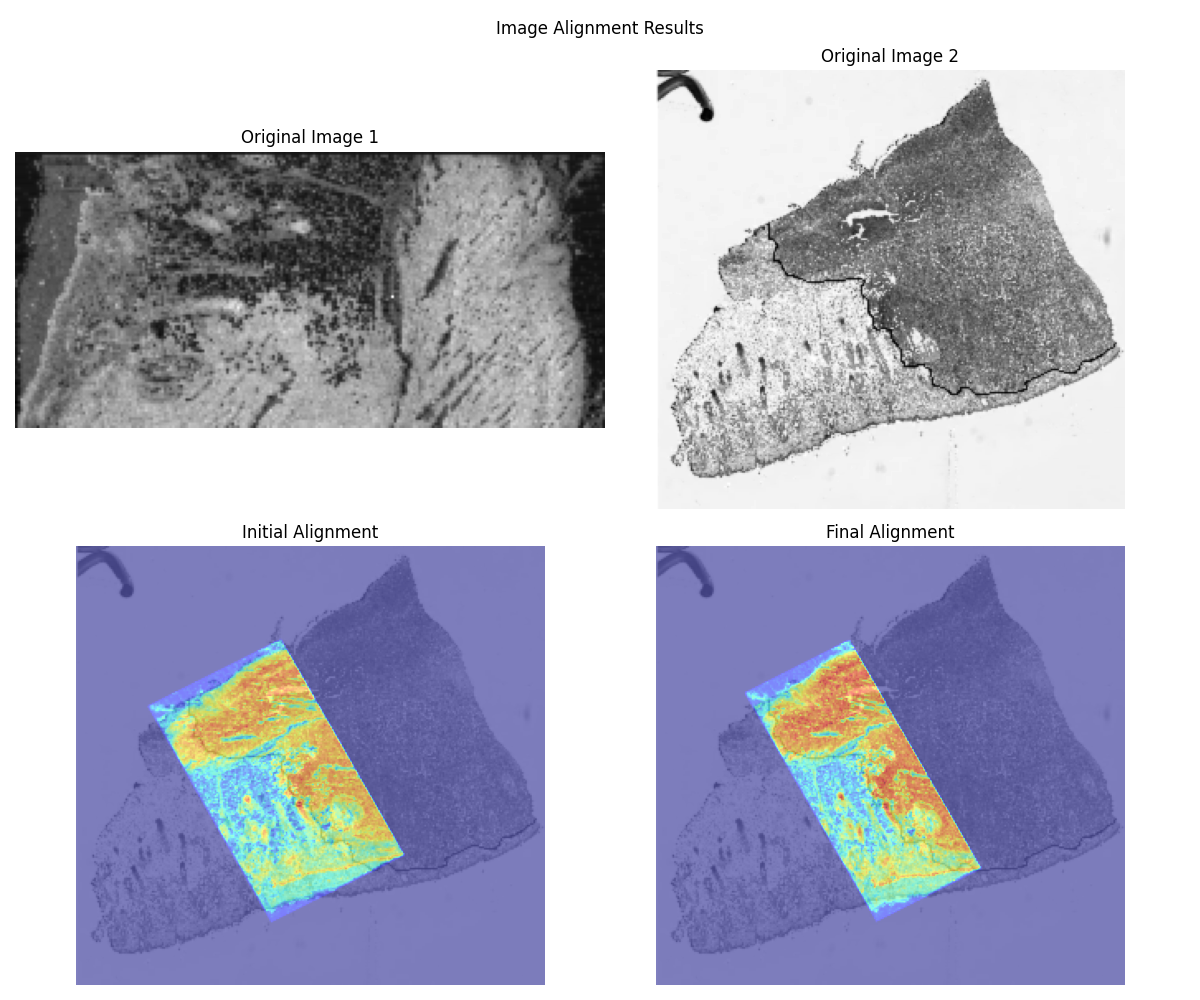

In [91]:
aligner.plot_alignment()